Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== RandomizedSearchCV completed ===
Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Best CV balanced accuracy: 0.4019347495703572
              precision    recall  f1-score   support

        High       0.58      0.56      0.57        75
         Low       0.32      0.25      0.28        28
      Medium       0.49      0.63      0.55        78
 Medium High       0.30      0.22      0.25        46

    accuracy                           0.48       227
   macro avg       0.42      0.41      0.41       227
weighted avg       0.46      0.48      0.46       227

Balanced Accuracy: 0.4138991081382386
F1 Macro: 0.41378873153585144


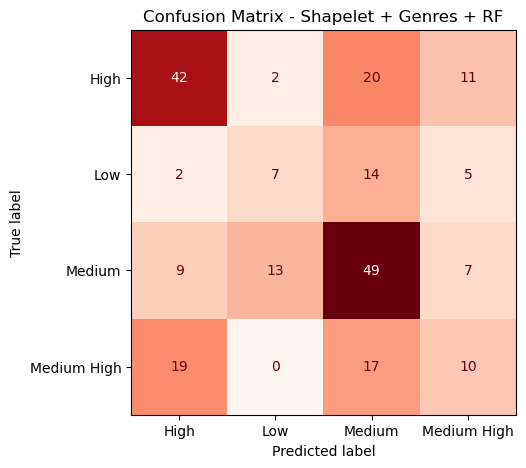

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


# --- Caricamento dataset ---
df = pd.read_csv("/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv")



# --- Preprocessing genre ---
df['genre'] = df['genre'].apply(lambda x: x.split(',') if pd.notna(x) else x)
# clean genre column from [, ], '
df['genre'] = df['genre'].apply(
    lambda x: [i.strip().replace("'", "").replace("[", "").replace("]", "") for i in x] if isinstance(x, list) else x
)

# Compute frequency encoding for each genre
from collections import Counter
genre_counts = Counter(genre for sublist in df['genre'].dropna() for genre in sublist)
genre_freq = {genre: count / len(df) for genre, count in genre_counts.items()}

# convert genre column into genre1, genre2, genre3 columns, sorting on frequency
df['genre'] = df['genre'].apply(lambda x: sorted(x, key=lambda y: genre_freq.get(y, 0), reverse=True) if isinstance(x, list) else x)

genre_cols = ['genre1', 'genre2', 'genre3']

df[genre_cols] = pd.DataFrame(df['genre'].tolist(), index=df.index).iloc[:, :3]
df = df.drop(columns=['genre'])

# convert genre columns into frequency encoding
df['genre1'] = df['genre1'].map(genre_freq)
df['genre2'] = df['genre2'].map(genre_freq)
df['genre3'] = df['genre3'].map(genre_freq)

df = df.fillna(0)

#sto aggiungendo qui!
X_genres = df[genre_cols].fillna(0).values





# Merge classi poco rappresentate
df["rating_category"] = df["rating_category"].replace({"Medium Low": "Low"})

# Feature e target
X_ts = df.iloc[:, 1:100].values
y = df["rating_category"].values

# Encoding target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Split dati ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X_ts, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
# )
X_train_ts, X_test_ts, X_train_genre, X_test_genre, y_train, y_test = train_test_split(
    X_ts, X_genres, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Log-transform + Normalizzazione ---
X_train_log = np.log1p(X_train_ts)
X_test_log = np.log1p(X_test_ts)

scaler_ts = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler_ts.fit_transform(X_train_log)
X_test_scaled = scaler_ts.transform(X_test_log)

# Conversione in formato nested per sktime
X_train_nested = from_2d_array_to_nested(X_train_scaled.squeeze())
X_test_nested = from_2d_array_to_nested(X_test_scaled.squeeze())

# ==========================
# Shapelet Transform + RandomizedSearchCV su RandomForest
# ==========================
shapelet_transform = RandomShapeletTransform(
    max_shapelets=200,
    min_shapelet_length=3,
    max_shapelet_length=30,
    random_state=42,
    n_jobs=-1
)


shapelet_transform.fit(X_train_nested, y_train)

X_train_shapelets = shapelet_transform.transform(X_train_nested)
X_test_shapelets = shapelet_transform.transform(X_test_nested)

X_train_combined = np.hstack([X_train_shapelets, X_train_genre])
X_test_combined = np.hstack([X_test_shapelets, X_test_genre])

# Scaling finale
scaler_final = StandardScaler()
X_train_final = scaler_final.fit_transform(X_train_combined)
X_test_final = scaler_final.transform(X_test_combined)

#### CLASS WEIGHT BALANCED ####
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
#shapelet_pipeline = make_pipeline(shapelet_transform, rf_clf)

# # Parametri da ottimizzare per la Random Forest all'interno della pipeline
# param_dist = {
#     "randomforestclassifier__n_estimators": [100, 200, 300],
#     "randomforestclassifier__max_depth": [None, 10, 20, 30],
#     "randomforestclassifier__min_samples_split": [2, 5, 10],
#     "randomforestclassifier__min_samples_leaf": [1, 2, 4],
# }


param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,           
    cv=3,
    scoring="balanced_accuracy",   
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# random_search = RandomizedSearchCV(
#     shapelet_pipeline,
#     param_distributions=param_dist,
#     n_iter=10,
#     cv=3,
#     scoring="accuracy",
#     n_jobs=-1,
#     random_state=42
# )

# Fit della RandomizedSearch
random_search.fit(X_train_final, y_train)

print("\n=== RandomizedSearchCV completed ===")
print("Best params:", random_search.best_params_)
print("Best CV balanced accuracy:", random_search.best_score_)
# print("=== Shapelet Transform + RF (log-transformed) RandomizedSearchCV ===")
# print("Best params:", random_search.best_params_)
# print("Best CV accuracy:", random_search.best_score_)

# Valutazione sul test set
y_pred = random_search.predict(X_test_final)
# y_pred = random_search.predict(X_test_nested)
# print(classification_report(y_test, y_pred, target_names=le.classes_))

# cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(le.classes_)))
# plt.figure(figsize=(5, 5))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
# disp.plot(cmap="Reds", colorbar=False, ax=plt.gca())
# plt.xticks(rotation=0, ha='center')
# plt.yticks(rotation=0)
# plt.title("Confusion Matrix - Shapelet RF (log-transformed)")
# plt.show()


print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Reds", colorbar=False, ax=plt.gca())
plt.title("Confusion Matrix - Shapelet + Genres + RF")
plt.show()

=== Shapelet Transform + RF (log-transformed, class_weight='balanced') RandomizedSearchCV ===
Best params: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': None}
Best CV accuracy: 0.45754376762179527
              precision    recall  f1-score   support

        High       0.53      0.56      0.55        75
      Medium       0.47      0.73      0.58        78
 Medium High       0.35      0.13      0.19        46
  Medium Low       0.45      0.18      0.26        28

    accuracy                           0.48       227
   macro avg       0.45      0.40      0.39       227
weighted avg       0.47      0.48      0.45       227



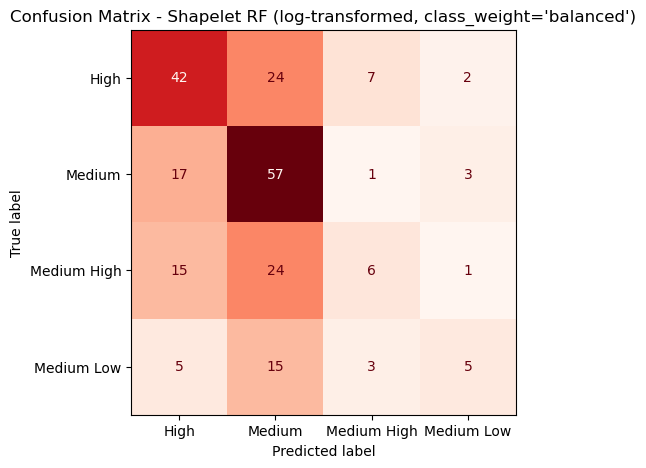

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# --- Caricamento dataset ---
df = pd.read_csv("/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv")

# Merge classi poco rappresentate
df["rating_category"] = df["rating_category"].replace({"Low": "Medium Low"})

# Feature e target
X_ts = df.iloc[:, 1:100].values
y = df["rating_category"].values

# Encoding target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Split dati ---
X_train, X_test, y_train, y_test = train_test_split(
    X_ts, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Log-transform + Normalizzazione ---
X_train_log = np.log1p(X_train)
X_test_log = np.log1p(X_test)

scaler_ts = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler_ts.fit_transform(X_train_log)
X_test_scaled = scaler_ts.transform(X_test_log)

# Conversione in formato nested per sktime
X_train_nested = from_2d_array_to_nested(X_train_scaled.squeeze())
X_test_nested = from_2d_array_to_nested(X_test_scaled.squeeze())

# ==========================
# Shapelet Transform + RandomizedSearchCV su RandomForest con class_weight='balanced'
# ==========================
shapelet_transform = RandomShapeletTransform(
    max_shapelets=200,
    min_shapelet_length=3,
    max_shapelet_length=30,
    random_state=42
)

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
shapelet_pipeline = make_pipeline(shapelet_transform, rf_clf)

# Parametri da ottimizzare per la Random Forest all'interno della pipeline
param_dist = {
    "randomforestclassifier__n_estimators": [100, 200, 300],
    "randomforestclassifier__max_depth": [None, 10, 20, 30],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
}

random_search = RandomizedSearchCV(
    shapelet_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

# Fit della RandomizedSearch
random_search.fit(X_train_nested, y_train)

print("=== Shapelet Transform + RF (log-transformed, class_weight='balanced') RandomizedSearchCV ===")
print("Best params:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

# Valutazione sul test set
y_pred = random_search.predict(X_test_nested)
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Reds", colorbar=False, ax=plt.gca())
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.title("Confusion Matrix - Shapelet RF (log-transformed, class_weight='balanced')")
plt.show()
